In [1]:
!rm *.nc*

# Sentinel-6 MF L2 Altimetry: OPeNDAP Access and Gridding

In this tutorial you will learn how to access variable subsets from OPeNDAP in the Cloud.

## Introduction

### Ocean Surface Topography

The primary contribution of satellite altimetry to satellite oceanography has been to:

* Improve the knowledge of ocean tides and develop global tide models.
* Monitor the variation of global mean sea level and its relationship to changes in ocean mass and heat content.
* Map the general circulation variability of the ocean, including the ocean mesoscale, over decades and in near real-time using multi-satellite altimetric sampling.

<img src="https://podaac.jpl.nasa.gov/sites/default/files/content/PO.DAAC_SAT_Timeline_high_res.jpg" width="60%">

The Surface Water Ocean Topography (SWOT) mission will bring together oceanography and hydrology to focus on gaining a better understanding of the world's oceans and its terrestrial surface waters. U.S. and French oceanographers and hydrologists have joined forces to develop this new space mission to make the first global survey of Earth's surface water, observe the fine details of the ocean's surface topography and measure how water bodies change over time. The payload on SWOT will include a Jason-class radar altimeter that will serve to extend the time series of sea surface height data into the future, beyond the lifespan of Sentinel-6 MF, which is introduced immediately below. Read more about SWOT at: https://podaac.jpl.nasa.gov/SWOT/    

### Sentinel-6 MF

The Sentinel-6 Michael Freilich radar altimeter mission is part of the Copernicus Programme, with the objective of providing high-precision measurements of global sea-level in the 2020–2030 time-frame (mission launched on November 21, 2020). A secondary objective is to collect high resolution vertical profiles of temperature, using the GNSS Radio-Occultation sounding technique, to assess temperature changes in the troposphere and stratosphere and to support Numerical Weather Prediction.

*About the science*:

* https://www.nasa.gov/sentinel-6
* https://sealevel.jpl.nasa.gov/missions/jasoncs/
* https://sentinel-6.cnes.fr/en/JASON-CS/index.htm

*About the datasets*:

* https://podaac.jpl.nasa.gov/Sentinel-6
* https://search.earthdata.nasa.gov/search?fpj=Sentinel-6
* https://www.aviso.altimetry.fr/?id=1693&L=0

### Requirements

This workflow was developed using Python 3.9 (and tested against versions 3.7, 3.8). The [`pyresample`](https://pyresample.readthedocs.io/en/latest/installation.html) package is the only remaining dependency besides common packages like `numpy` and `xarray`.

Uncomment the first line of the following cell to install *pyresample*, if necessary. Then, import all the required Python packages.

In [2]:
#!python -m pip install pyresample
import os
import tqdm
import requests
import numpy as np
import pandas as pd
import xarray as xr
import pyresample as pr
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from pyresample.kd_tree import resample_gauss
from io import StringIO

Define two functions to prepare metadata and opendap urls required for the demo.

In [3]:
cmr = "cmr.earthdata.nasa.gov"

def opendap(record: dict):
    for url in record.get("RelatedUrls"):
        if 'opendap.earthdata.nasa.gov' in url.get("URL"):
            return url.get("URL")

def search(ShortName: str, provider: str="POCLOUD", page_size: int=200, **kwargs):
    pars = dict(ShortName=ShortName, provider="POCLOUD", page_size=page_size)
    # Get metadata about the collection of interest:
    coll = requests.get(f"https://{cmr}/search/collections.umm_json", pars).json().get("items")[0]
    # Get a table of metadata about granules from the cycle of interest:
    granules = pd.DataFrame(requests.get(f"https://{cmr}/search/granules.umm_json", {**pars,**kwargs}).json().get("items"))
    granules['GranuleUR'] = granules.umm.apply(lambda x: x.get("GranuleUR"))
    # Store metadata about temporal coverage in the table:
    coverage = granules.umm.apply(lambda x: x.get("TemporalExtent").get("RangeDateTime").values()).apply(list)
    granules['StartTime'] = coverage.apply(sorted).apply(lambda x: x[0])
    granules['EndTime'] = coverage.apply(sorted).apply(lambda x: x[1])
    # Store OPeNDAP endpoints in the table:
    granules['OPeNDAP'] = granules['umm'].apply(opendap)
    return granules

### About This Dataset

***Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NRT Reduced Ocean Surface Topography***

https://doi.org/10.5067/S6AP4-2LRNR

Provides low resolution (LR) near real time (NRT; 3-hour latency) measurements of sea surface height anomaly (SSHA), Significant Wave Height (SWH), and Wind Speed. The NRT product is analogous to the Jason-3 OGDR product. The data are provided natively in netCDF-4 data and file format. The files conform to the specifications defined in the CF-1.7+ conventions documents.

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F.jpg" width="80%">

<i>Figure: depicted data structure for level-2 along-track altimetry datasets from Sentinel-6A</i>

**Names and Identifiers**

This example operates on Level 2 Low Resolution Altimetry from Sentinel-6 Michael Freilich (the Near Real Time Reduced distribution). It is most easily identified by its collection *ShortName*.

In [4]:
# Specify the ShortName of the target collection:
short_name = 'JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F'

# And specify its unique 'concept-id' in the CMR:
concept_id = "C1968980576-POCLOUD"

# Pick a recent cycle (e.g. 25, 26, 27, ...):
cycle = 25

# Gather info about granules from the target cycle into a table:
granules = search(short_name, cycle=cycle)

display(granules[['GranuleUR', 'StartTime', 'EndTime']].set_index("GranuleUR"))

,StartTime,EndTime
GranuleUR,,
S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02,2021-07-13T16:26:44.514Z,2021-07-13T18:22:34.471Z
S6A_P4_2__LR_RED__NR_025_003_20210713T182234_20210713T201839_F02,2021-07-13T18:22:34.522Z,2021-07-13T20:18:39.482Z
S6A_P4_2__LR_RED__NR_025_006_20210713T201839_20210713T215450_F02,2021-07-13T20:18:39.532Z,2021-07-13T21:54:50.473Z
S6A_P4_2__LR_RED__NR_025_007_20210713T215450_20210713T234732_F02,2021-07-13T21:54:50.523Z,2021-07-13T23:47:32.482Z
S6A_P4_2__LR_RED__NR_025_009_20210713T234732_20210714T014224_F02,2021-07-13T23:47:32.533Z,2021-07-14T01:42:24.454Z
...,...,...
S6A_P4_2__LR_RED__NR_025_245_20210723T050533_20210723T064603_F02,2021-07-23T05:05:33.543Z,2021-07-23T06:46:03.471Z
S6A_P4_2__LR_RED__NR_025_247_20210723T064603_20210723T083817_F02,2021-07-23T06:46:03.521Z,2021-07-23T08:38:17.483Z
S6A_P4_2__LR_RED__NR_025_249_20210723T083817_20210723T103256_F02,2021-07-23T08:38:17.533Z,2021-07-23T10:32:56.490Z


### Accessing Data in/from the Cloud

This workflow example downloads subsets of the netcdf datasets via OPeNDAP for massive efficiency gains (network/compute).

**Access for direct download:**

* Browse and download granules through Earthdata Search -- https://search.earthdata.nasa.gov/search/granules?p=C1968980576-POCLOUD
* Browse and download granules from HTTPS endpoints -- https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1968980576-POCLOUD
* Browse and download granules from S3 endpoints (example forthcoming, assuming s3 direct access has been enabled for the collection)

**Access through data services:**

Our datasets are also accessible in reduced forms through higher-level cloud data services, for example:

* https://harmony.earthdata.nasa.gov/ -- Data reduction via on-demand subsetting and other high-level reformatting
    * Provides access to backend services such as data file format conversion, subsetting at L2+, regridding and reprojection at L3+, and more.
    * Compatibility depends on the data processing level and data/file format, and so their expected behavior vary also.
    * Services available through Harmony API reduce the technical burden on users by covering certain low-level data transformations that a user would normally have to apply themselves, even to simply subset a dataset from OPeNDAP.
* https://opendap.earthdata.nasa.gov/ -- Data reduction via basic subsetting along coordinate dimensions and by variable 
    * Requires more familiarity with the contents of the target dataset, as well knowledge of how to select for data along the dimensions which correspond to space/time coordinates fitting the geographic and temporal coverage of interest.
    * User Guide: https://opendap.github.io/documentation/UserGuideComprehensive.html
    
### OPeNDAP in the Cloud

* What is it capable of?
* Why use it over other subset services, in this example?

Prepare the full request urls by assembling a comma-delimited list of variables in the query portion of each OPeNDAP endpoint, i.e. appended a question mark `?` and then the comma-delimited list. This next cell takes care of that step (and the link printed below should trigger a subset download through the web browser).

In [5]:
dapurl = f"https://opendap.earthdata.nasa.gov/collections/{concept_id}"

variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']

dapvar = ",".join(variables)

urls = granules.GranuleUR.apply(lambda f: f"{dapurl}/granules/{f}.nc4?{dapvar}")

print(urls[0])

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha


The function(s) below download granules from a remote `source` to a local `target` file, and reliably manage simultaneous streaming downloads divided between multiple threads.

In [6]:
def download(source: str):
    target = os.path.basename(source.split("?")[0])
    if not os.path.isfile(target):
        !wget --quiet --continue --output-document $target $source
    return target

def download_all(urls: list, max_workers: int=12):
    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        workers = pool.map(download, urls)
        return list(tqdm.tqdm(workers, total=len(urls)))

files = download_all(urls=urls, max_workers=12)

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


The source files range from 2.5MB to 3.0MB. These OPeNDAP subsets are ~100KB apiece. (anecdote: it took less than 10 minutes to download subsets for >1700 granules/files when I ran this routine for all cycles going back to 2021-06-22.)

In [7]:
!du -sh .

14M	.


#### Aggregate cycle

Sort the list of local subsets to ensure they concatenate in proper order. Call `open_mfdataset` on the list to open all the subsets in memory as one dataset in xarray.

In [8]:
ds = xr.open_mfdataset(sorted(files), engine="netcdf4")

# Rename variables to drop group names prepended by opendap:
new_variable_names = list(map(lambda x: x.split("_")[-1], variables))
map_variable_names = dict(zip(variables, new_variable_names))
ds = ds.rename(map_variable_names) \
       .set_coords(['time', 'longitude', 'latitude'])

print(ds)

<xarray.Dataset>
Dimensions:    (time: 827001)
Coordinates:
    longitude  (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    latitude   (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2021-07-13T16:26:45 ... 2021-07-23T14:25:14
Data variables:
    ssha       (time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
Attributes: (12/63)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____SURF_AX_20151008T000000...
    xref_wind_speed_alt:            

#### Plot *ssha* variable

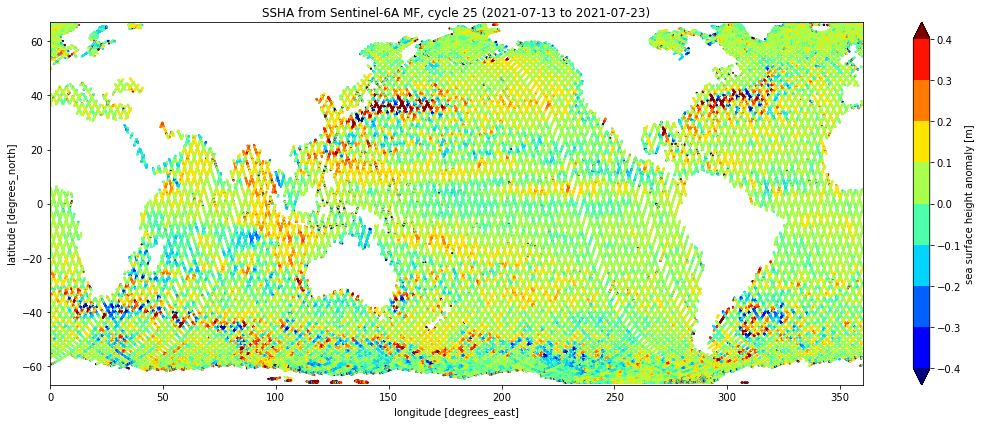

In [9]:
ds.plot.scatter(y="latitude",
                x="longitude", 
                hue="ssha",
                vmin=-0.4,
                vmax=0.4,
                levels=9, 
                cmap="jet",
                aspect=2.5,
                size=6,
                s=1, )
start, end = [str(x).split('T')[0] for x in [ds.time.data[0], ds.time.data[-1]]]
plt.title(f"SSHA from Sentinel-6A MF, cycle {cycle} ({start} to {end})")
plt.ylim(-67., 67.)
plt.xlim(0., 360.)
plt.tight_layout()

### Render to 0.5-degree geographic grid from ECCO V4r4

>*Acknowledgement: This approach using [*pyresample*](https://pyresample.readthedocs.io/en/latest/api/pyresample) was shared by Ian Fenty, ECCO Lead.*

ECCO V4r4 products are distributed in two spatial formats. One set of collections provides the ocean state estimates on the native model grid (LLC0090) and the other provides them after interpolating to a regular grid defined in geographic coordinates with horizontal cell size of 0.5-degrees. The latitude/longitude grid is distributed as its own collection in one netcdf file: https://search.earthdata.nasa.gov/search/granules?p=C2013583732-POCLOUD

Download the ECCO grid geometry netcdf from its https download endpoint in NASA Earthdata Cloud. Open the file and print the header content for the `maskC` variable, which contains a boolean mask representing the wet/dry state of the area contained in each cell of a 3d grid with dimensions mapped to `Z`, `latitude`, and `longitude`.

In [10]:
ecco_file = download("https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/"
                     "ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc")

# Open it and select position 0 on axis `Z`:
ecco_grid = xr.open_dataset(ecco_file).isel(Z=0)

# Select variable `maskC`, which provides a land/water mask:
ecco_mask = ecco_grid.maskC

print(ecco_mask)

<xarray.DataArray 'maskC' (latitude: 360, longitude: 720)>
[259200 values with dtype=bool]
Coordinates:
    Z          float32 -5.0
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              wet/dry boolean mask for grid cell
    comment:                True for grid cells with nonzero open vertical fr...


#### Grid the *ssha* variable

Resample *ssha* data using kd-tree gaussian weighting neighbour approach. Define a function that implements the following steps:

1. Generate two 2d arrays of lats/lons using the permuted 1d coordinates from an input gridded dataset.
2. Define the target grid geometry using the 2d arrays of lats/lons.
3. Define the source grid geometry using the 1d arrays of lats/lons from an input dataset.

In [11]:
def l2alt2grid(source: xr.DataArray, target: xr.DataArray, **options):
    ## Define a grid from the input 'source' array's coordinates -->
    nans = ~np.isnan(source.values)
    # Mask NaNs from source data and its coordinate arrays:
    data = source.values[nans]
    lats = source.latitude.values[nans]
    lons = (source.longitude.values[nans] + 180) % 360 - 180
    # Define source grid for gridding with 'pyresample':
    srcgrid = pr.SwathDefinition(lons, lats)
    ## Define a grid from the input 'target' array's coordinates -->
    lons1d = target.longitude.values
    lats1d = target.latitude.values
    # Permute the two arrays of coordinates to produce two 2d coordinate arrays:
    lons2d, lats2d = np.meshgrid(lons1d, lats1d)
    # Define target grid for gridding with 'pyresample':
    dstgrid = pr.SwathDefinition(lons2d, lats2d)
    ## Resample source data to target grid -->
    res, std, cnt = resample_gauss(srcgrid, data, dstgrid, **options)
    ## Return gridded data and grid statistics -->
    coords = {'latitude':  lats1d, 'longitude': lons1d}
    return ( xr.DataArray(res, coords=coords),
             xr.DataArray(std, coords=coords),
             xr.DataArray(cnt, coords=coords), )

# A dictionary of gridding parameters to be passed to the 'l2alt2grid' function:
gridding_options = dict(radius_of_influence=175000,  
                        sigmas=25000,
                        neighbours=100,
                        fill_value=np.nan,
                        with_uncert=True, )

# Call 'l2alt2grid' to map the 'ssha' variable to the grid supplied by ECCO V4r4:
result, stddev, counts = l2alt2grid(ds.ssha, ecco_mask, **gridding_options)

# Confirm size of output array matches ECCO V4r4 grid dimensions:
result.shape == (ecco_grid.latitude.size, ecco_grid.longitude.size)

/home/admin/conda/envs/geo/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 175000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


True

#### Plot ssha grid and grid statistics

Plot each array for the output 'grid' and the grid statistics 'stddev' and 'counts'.

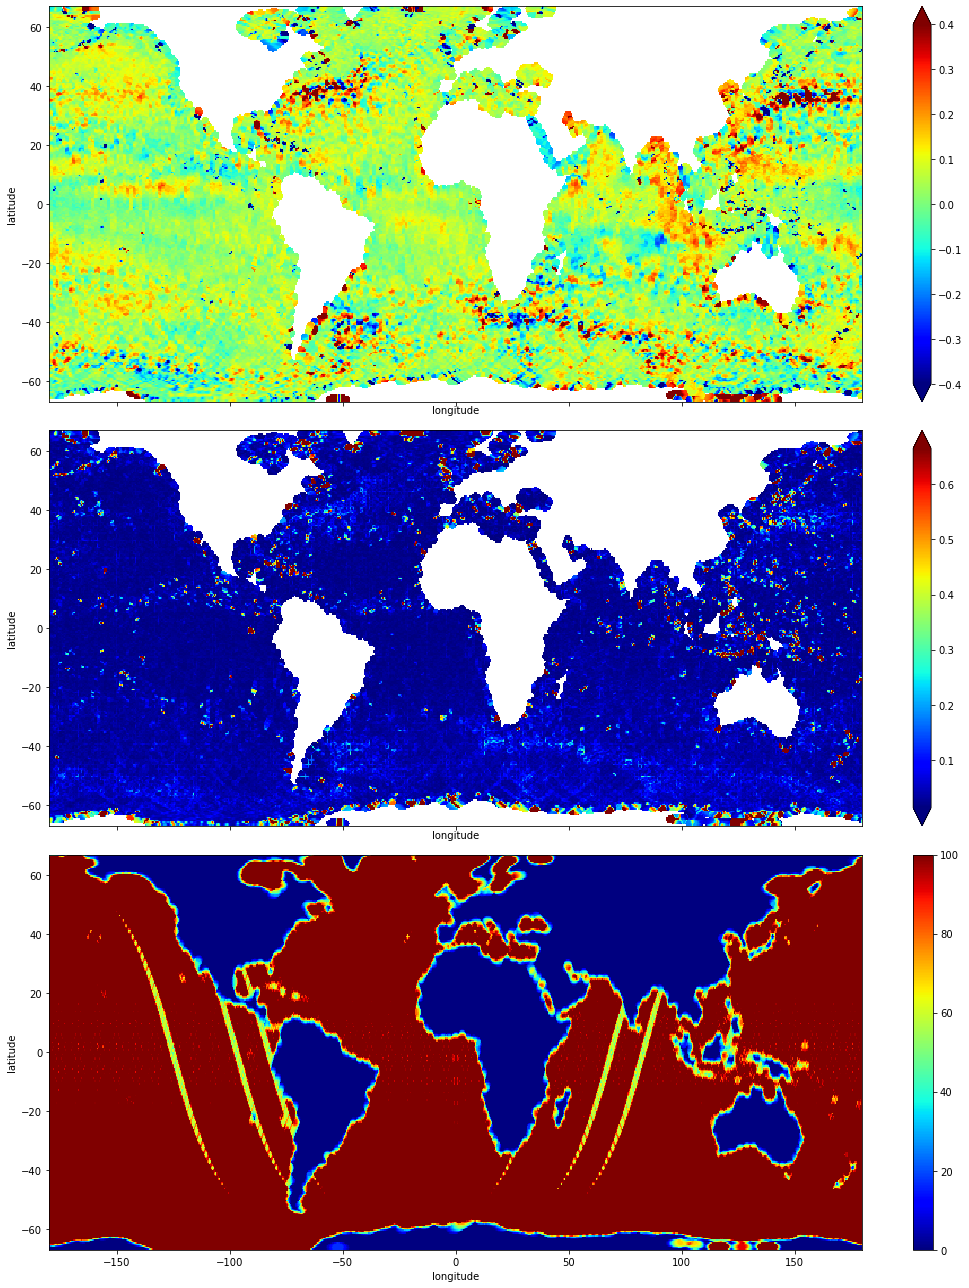

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(15, 18))

for i, g in enumerate([result, stddev, counts]):
    if i==0:
        kwargs = dict(vmin=-0.4, vmax=0.4) 
    else:
        kwargs = dict(robust=True)

    g.sel(latitude=slice(-67., 67.)).plot(cmap="jet", ax=axes[i], **kwargs)
    
plt.tight_layout()

### References

* *Bash*
    * https://www.gnu.org/software/coreutils/manual/html_node/du-invocation.html
* *Python*
    * https://docs.python.org/3/library/functions.html#map    
    * https://docs.python.org/3/library/functions.html#zip
    * https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor
* *numpy* (https://numpy.org/doc/stable/reference)    
    * [numpy.ndarray.data](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.data.html)      
    * [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)    
    * [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html)    
    * [datetimes](https://numpy.org/doc/stable/reference/arrays.datetime.html)    
    * [numpy.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)    
    * [numpy.nansum](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html)    
* *xarray* (https://xarray.pydata.org/en/stable)    
    * [xarray.DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)    
    * [xarray.DataArray.values](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html)    
    * [xarray.DataArray.mean](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html)    
    * [xarray.DataArray.isel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html)
    * [xarray.open_dataset](https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
    * [xarray.DataArray.plot](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html)
    * [xarray.Dataset.rename](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html)
* *pyresample*
    * [pyresample.geometry.SwathDefinition](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.geometry.SwathDefinition)
    * [pyresample.kd_tree.resample_gauss](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.kd_tree.resample_gauss)